In [1]:
import warnings
warnings.filterwarnings('ignore')

## Introduction

The last two days we have learnt how to deal with seismic data using python and some available libraries. Now, you have confident in working with various libraries as well as writing your own code if necessary! (rememmber we are not here to invent the wheel!) Today, we will go through some applications of machine learning in sesmic data analysis. A literature search was conducted to identify the relevant studies and articles based on abstract
and title words and citation relation. Data were collected from the Web of Science Core
Correction in the period of 1900–2020.Various keywords were used to increase the chance of
finding more relevant publications: "Seismic + machine learning", "Seismic + data science", ....
Let's take a look at some analysis:

<img src="data/years.jpg" width=1000 height=1000 />

<div class="alert alert-block alert-danger">
You can see the number of publications has been increased exponentially! <div>

<img src="data/keywords1.png" width=500 height=500 />

<div class="alert alert-block alert-danger">
Here is the most repeated keywords clustered 

<div class="alert alert-block alert-info">
I suggest you to do some data analysis with job ads websites to see how data science in seismic is getting popular in job anouncements over the years </div>

Today we will look at one example together! We will show you a very basic solution for each and expect you to improve them in a group. Note that the data here are not perfect and good, it is just more of a reminder of what you have learnt last term not a real machine learning project!
For reading more please check bellow links:
- [Seismic Data Exploration](https://www.kaggle.com/code/jsaguiar/seismic-data-exploration)
- [Intro to seismic, salt](https://www.kaggle.com/code/bit3125/intro-to-seismic-salt-and-how-to-geophysi-07a2b8)
- You worked with earthquacke data damage in Machine Learning and Data Science module with Cedric, if you are interested more on working with this data feel free to send a message in teams! 
[Earthquakes And Tectonic Plates: Seismic Analysis](https://www.kaggle.com/code/karnikakapoor/earthquakes-and-tectonic-plates-seismic-analysis)

## Practical 1: Mapping salt in 2-D seismic image

In [3]:
from sys import stdout

import random
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

from sklearn.metrics import confusion_matrix

In [4]:
data = mpimg.imread('data/seismic.tif')


In [5]:
data.shape

(1036, 2350, 3)

In [6]:
mask = mpimg.imread('data/mask.tif')


In [7]:
mask.shape

(1036, 2350)

In [8]:
# Remmeber to scale your data manually!
data = data[:,:,:1]/255
mask = (mask-mask.min())/(mask.max()-mask.min())


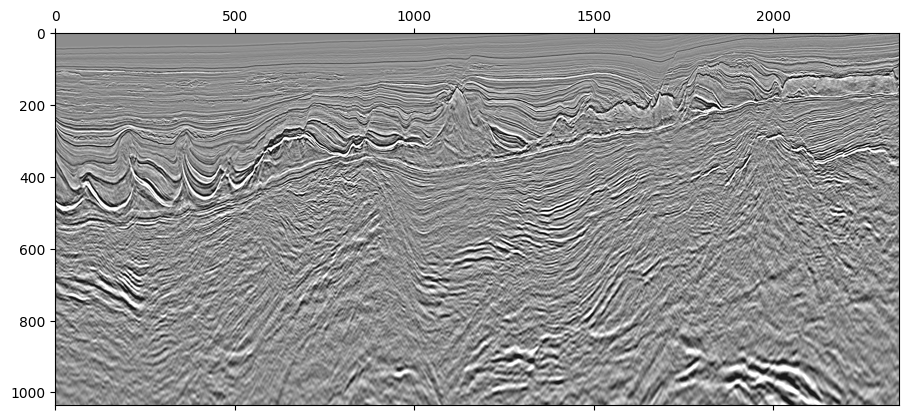

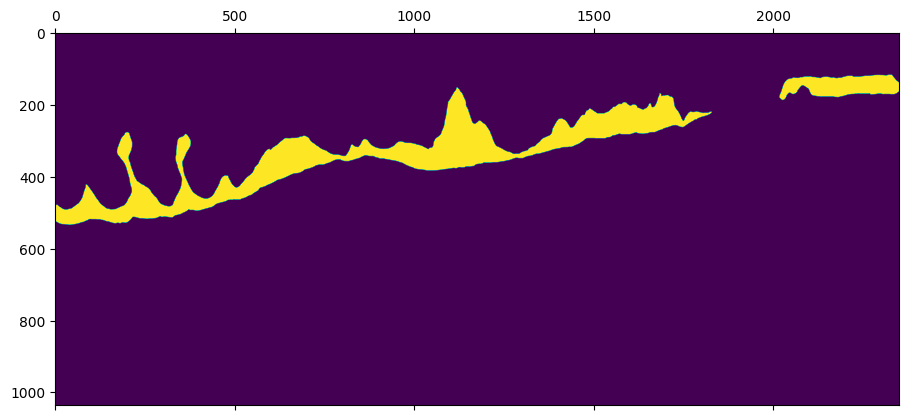

In [9]:
plt.matshow(data[:,:,0], interpolation='spline16', cmap=plt.cm.gray, aspect=1)
plt.matshow(mask, interpolation='spline16', aspect=1)

So now we have one image with a mask, but we need many more examples to train a deep learning model. Of course, we could label more examples, but that takes time and additional data. Let's say we have neither of those. In this case, we can split up our image and mask in to many pairs of small patches. So let's do that:

In [10]:
def patchify(data, mask, patch_num, dim):

  X = np.empty((patch_num, *dim))
  y = np.empty((patch_num,2))

  (t_max, x_max, _) = data.shape

  for n in range(patch_num):
      
      # Select random point in data (not at the edge)   
      x_n = random.randint(dim[1]//2,x_max-dim[1]//2)
      t_n = random.randint(dim[0]//2,t_max-dim[0]//2)
      
      # Extract data patch around point   
      X[n,:,:,0] = data[t_n-dim[0]//2:t_n+dim[0]//2,x_n-dim[1]//2:x_n+dim[1]//2,0]
      
      # Note label of point (one-hot-encoding) zero for non salt and one for salt  
      y[n,0] = mask[t_n,x_n]
      y[n,1] = 1 - mask[t_n,x_n]

  return X, y

In [12]:
number_train = 5000                             # Number of training examples
number_test   = 1000                             # Number of validation examples
dim          = (64,64,1)                        # Size of examples

X_train, y_train = patchify(data[:,:1200], mask[:,:1200], number_train, dim)
X_test,   y_test   = patchify(data[:,1200:], mask[:,1200:], number_test, dim)

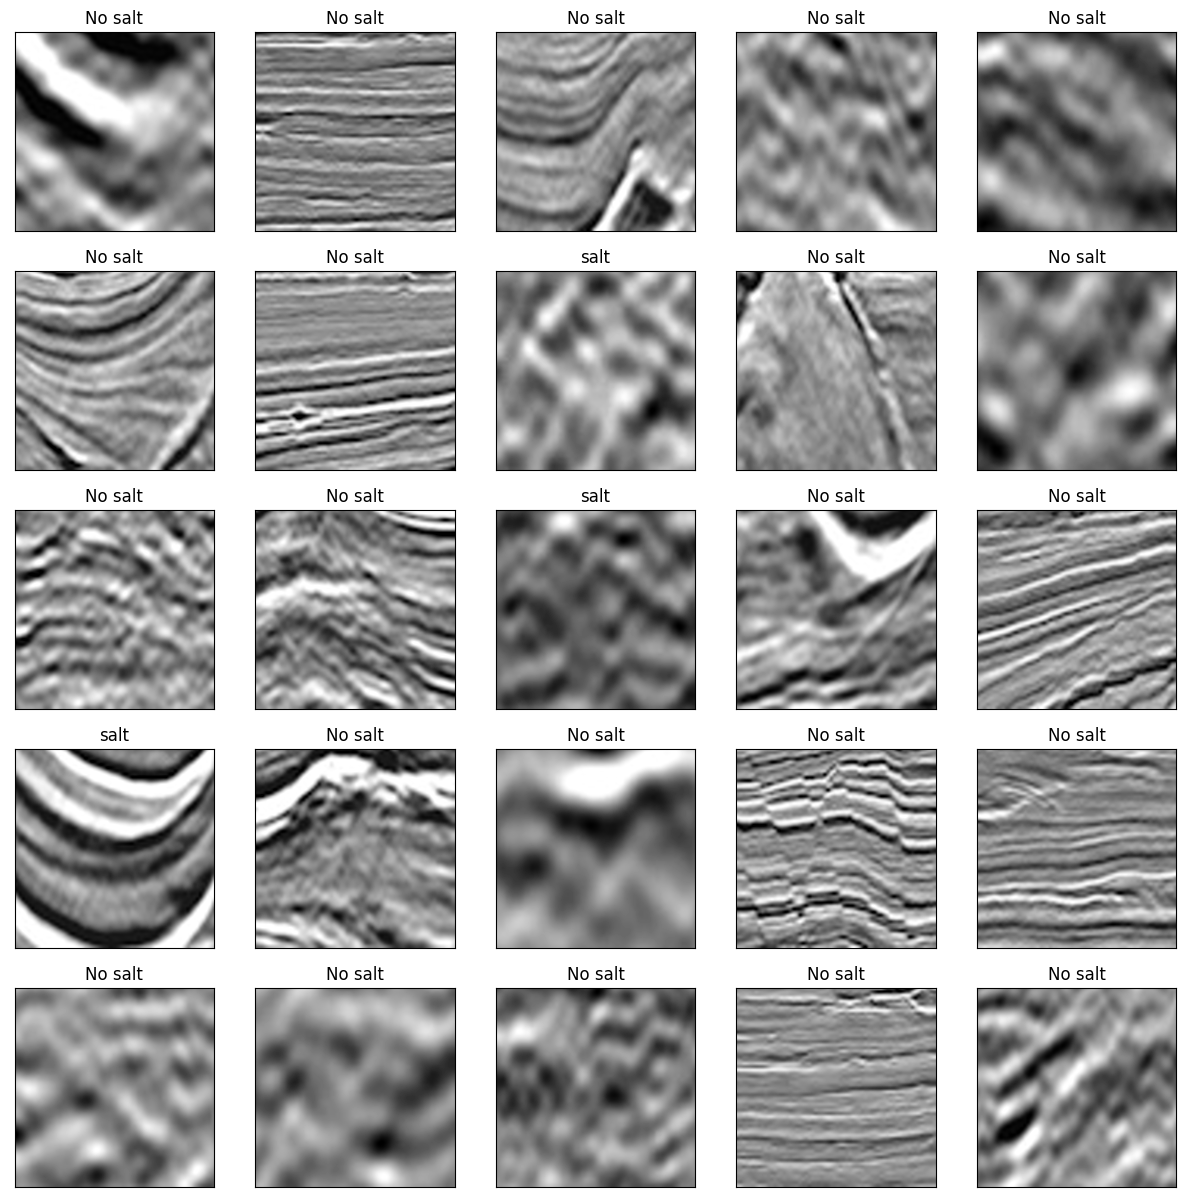

In [13]:
fig, axs = plt.subplots(5, 5, figsize=(15,15))

k = 0
for n in range(5):
  for m in range(5):
    axs[n,m].imshow(X_train[k,:,:,0], interpolation='spline16', cmap=plt.cm.gray, aspect=1)
    axs[n,m].set_xticks([])
    axs[n,m].set_yticks([])
    k += 1
    if y_train[k,0] == 1:
      axs[n,m].set_title('salt')
    else:
      axs[n,m].set_title('No salt')

In [19]:
model = Sequential([Conv2D(16, 3, padding='same', activation='relu', input_shape=dim),
                    MaxPooling2D(),
                    Dropout(0.2),
                    Conv2D(32, 3, padding='same', activation='relu'),
                    MaxPooling2D(),
                    Dropout(0.2),
                    Conv2D(64, 3, padding='same', activation='relu'),
                    MaxPooling2D(),
                    Dropout(0.2),
                    Flatten(),
                    Dense(512, activation='relu'),
                    Dense(2, activation='softmax')])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 32, 32, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 32)       

In [20]:
cnn_training = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=10)

Epoch 1/10
157/157 [==============================] - 4s 25ms/step - loss: 0.2797 - binary_accuracy: 0.9174 - val_loss: 0.2329 - val_binary_accuracy: 0.9500
Epoch 2/10
157/157 [==============================] - 4s 25ms/step - loss: 0.2176 - binary_accuracy: 0.9282 - val_loss: 0.2711 - val_binary_accuracy: 0.9260
Epoch 3/10
157/157 [==============================] - 4s 24ms/step - loss: 0.1720 - binary_accuracy: 0.9414 - val_loss: 0.2944 - val_binary_accuracy: 0.8890
Epoch 4/10
157/157 [==============================] - 4s 26ms/step - loss: 0.1384 - binary_accuracy: 0.9518 - val_loss: 0.2205 - val_binary_accuracy: 0.9260
Epoch 5/10
157/157 [==============================] - 4s 25ms/step - loss: 0.1181 - binary_accuracy: 0.9570 - val_loss: 0.2294 - val_binary_accuracy: 0.9200
Epoch 6/10
157/157 [==============================] - 4s 28ms/step - loss: 0.1138 - binary_accuracy: 0.9616 - val_loss: 0.2301 - val_binary_accuracy: 0.9350
Epoch 7/10
157/157 [==============================] - 5s 2

In [21]:
test_loss = model.evaluate(X_test, y_test) 

32/32 [==============================] - 0s 9ms/step - loss: 0.2178 - binary_accuracy: 0.9420


In [24]:
cnn_score = model.evaluate(X_test, y_test)[1]
cnn_score

32/32 [==============================] - 0s 9ms/step - loss: 0.2178 - binary_accuracy: 0.9420


0.9419999718666077

In [26]:
history = cnn_training.history

In [27]:
history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

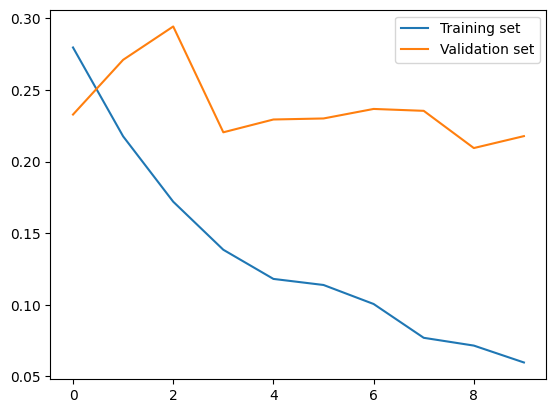

In [28]:
plt.plot(cnn_training.history['loss'], label='Training set')
plt.plot(cnn_training.history['val_loss'], label='Validation set')
plt.legend()

99

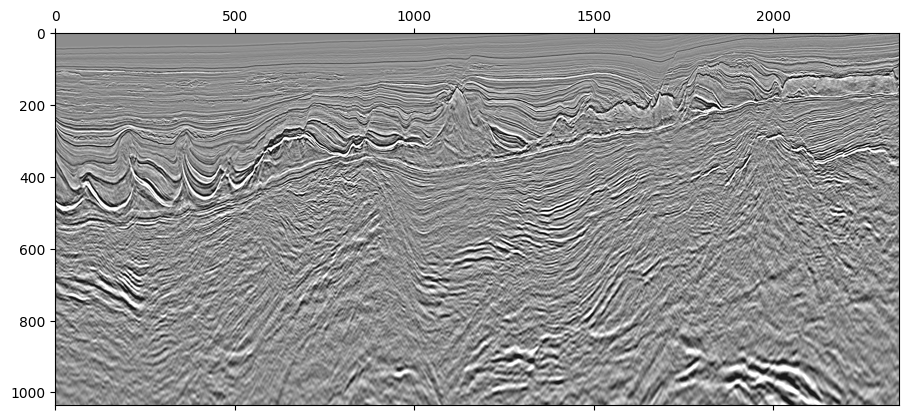

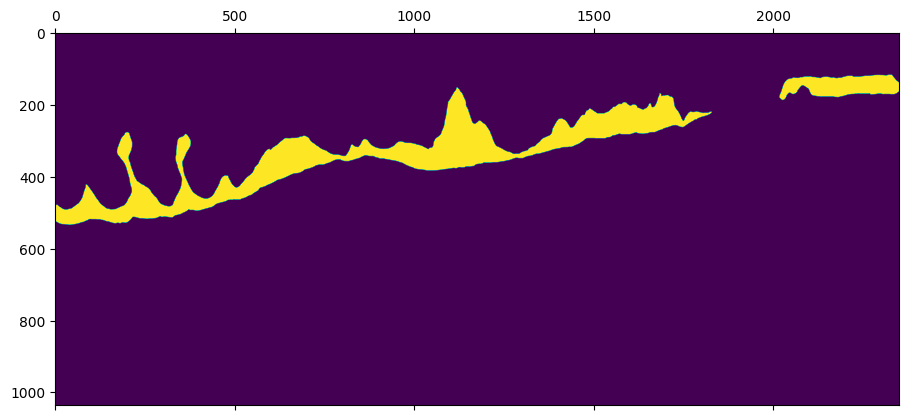

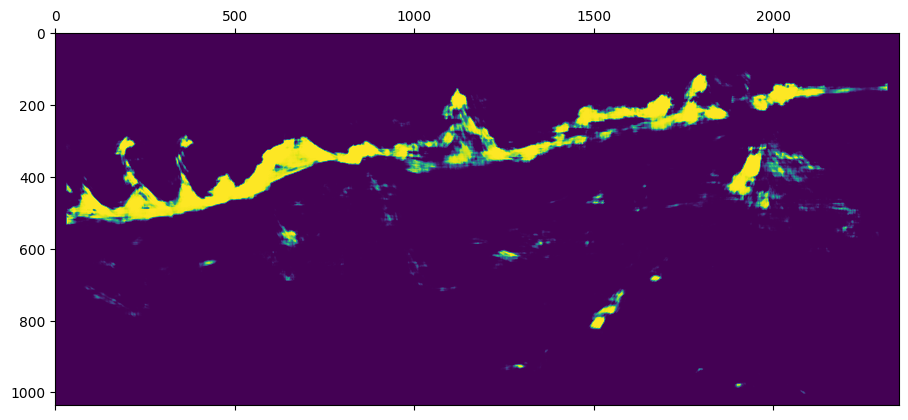

In [29]:
(t_max, x_max, _) = data.shape
result            = np.zeros((t_max,x_max,2))
batch             = np.zeros((t_max-dim[1], *dim))

m = 0
n = 0
for x in range(dim[0]//2,x_max-dim[0]//2): 
  stdout.write("\r%d" % m)
  stdout.flush()
  m = m + 100/(x_max-dim[0])

  for t in range(dim[1]//2,t_max-dim[1]//2):
    batch[n,:,:,0] = data[t-dim[1]//2:t+dim[1]//2, x-dim[0]//2:x+dim[0]//2, 0] 
    n = n + 1

  result[dim[1]//2:t_max-dim[1]//2,x,:] = model.predict_on_batch(batch)
  n = 0

plt.matshow(data[:,:,0], interpolation='spline16', cmap=plt.cm.gray, aspect=1)
plt.matshow(mask, interpolation='spline16', aspect=1)
plt.matshow(result[:,:,0], interpolation='spline16', aspect=1)
plt.show()
